# Classificação de Texto

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tarfile
import requests
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

2024-01-12 17:03:00.754927: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 17:03:00.791638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 17:03:00.791676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 17:03:00.792696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 17:03:00.798948: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.15.0


Primeiramente, num primeiro caderno, tentou-se utilizar o teor completo do dataset 'aclImdb_v1.tar.gz', mas devido à CUDA não estar atualizada para o uso da GPU Tesla T4 remota, precisamos utilizar um subconjunto de arquivos ou diretórios para o treinamento. Assim, num segundo momento foram extraídas apenas testes e treinamentos negativos e positivos.
Devido au uso de muita memória por parte da CPU, resolvemos fazer como sugerido pelo próprio caderno, e aceitar o uso da GPU Tesla T4 Nvidia, passemos ao resutado:

In [3]:
tf.debugging.set_log_device_placement(True)

# Place tensors on the CPU
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

2024-01-12 17:03:02.621079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 857 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
!sudo -E python3 -m pip install tensorflow[and-cuda]
# Verify the installation:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-01-12 17:03:13.679440: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 17:03:13.715607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 17:03:13.715650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 17:03:13.716697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 17:03:13.722257: I tensorflow/core/platform/cpu_feature_guar

A GPU fora instalada com êxito! 

## Análise de sentimento
Este notebook treina um modelo de análise de sentimento para classificar avaliações de filmes para um dataset do IMDB, como positivas ou negativas, com base no texto da avaliação. Este é um exemplo de classificação *binária*, ou de duas classes, um tipo de problema de aprendizado de máquina importante, com diversas aplicações.

In [6]:
# URL do dataset IMDB
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Baixando o arquivo
file_path = "aclImdb_v1.tar.gz"

# Salve o conteúdo do arquivo baixado
# Extrair o arquivo

# O diretório agora contém a pasta extraída 'aclImdb'
dataset_dir = 'aclImdb'
print("Conteúdo do diretório:", os.listdir(dataset_dir))

Conteúdo do diretório: ['imdbEr.txt', 'README', 'imdb.vocab', 'train', 'test']


In [7]:
# Definindo os caminhos dos diretórios
test_neg_dir = os.path.join(dataset_dir, 'test', 'neg')
test_pos_dir = os.path.join(dataset_dir, 'test', 'pos')
train_neg_dir = os.path.join(dataset_dir, 'train', 'neg')
train_pos_dir = os.path.join(dataset_dir, 'train', 'pos')

# Listando os primeiros itens para cada diretório
print("Alguns arquivos em test/neg:", os.listdir(test_neg_dir)[:5])
print("Alguns arquivos em test/pos:", os.listdir(test_pos_dir)[:5])
print("Alguns arquivos em train/neg:", os.listdir(train_neg_dir)[:5])
print("Alguns arquivos em train/pos:", os.listdir(train_pos_dir)[:5])

Alguns arquivos em test/neg: ['3112_1.txt', '6937_4.txt', '11011_2.txt', '5584_1.txt', '8119_4.txt']
Alguns arquivos em test/pos: ['11495_8.txt', '6303_9.txt', '11427_7.txt', '6855_7.txt', '3866_9.txt']
Alguns arquivos em train/neg: ['5056_2.txt', '5584_1.txt', '5708_1.txt', '8507_1.txt', '3294_3.txt']
Alguns arquivos em train/pos: ['1346_9.txt', '229_10.txt', '2665_10.txt', '1395_10.txt', '8602_10.txt']


In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'labeledBow.feat',
 'urls_unsup.txt',
 'neg',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat']

In [9]:
# Os diretórios aclImdb/train/pos e aclImdb/train/neg contêm diversos arquivos de texto, sendo que cada um é uma única avaliação de filme. Vamos dar uma olhada em um desses arquivos.
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [10]:
# O dataset do IMDB já foi dividido em conjuntos de treinamento e teste, mas ainda falta um de validação. Vamos criar um conjunto de validação utilizando uma divisão 80/20 para os dados do treinamento por meio do argumento validation_split abaixo

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerC

2024-01-12 17:03:16.761172: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:16.761206: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:16.761210: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:16.786300: I tensorflow/core/common_runtime/placer.cc:125] components_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:16.786341: I tensorflow/core/common_runtime/placer.cc:125] TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:16.786347: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:16.800374: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:GPU:0


2024-01-12 17:03:17.106393: I tensorflow/core/common_runtime/placer.cc:125] condition: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:17.106421: I tensorflow/core/common_runtime/placer.cc:125] t: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:17.106425: I tensorflow/core/common_runtime/placer.cc:125] e: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:17.106431: I tensorflow/core/common_runtime/placer.cc:125] SelectV2: (SelectV2): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:17.106434: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0


Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


2024-01-12 17:03:17.684016: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.684055: I tensorflow/core/common_runtime/placer.cc:125] DummySeedGenerator: (DummySeedGenerator): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.689651: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.689678: I tensorflow/core/common_runtime/placer.cc:125] buffer__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.689682: I tensorflow/core/common_runtime/placer.cc:125] seed: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.689686: I tensorflow/core/common_runtime/placer.cc:125] seed2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.689689: I tensorflow/core/common_runtime/placer.cc:125] seed__generator: (_Arg): /job:localhost/replica:0/task:

In [11]:
# Como podemos ver acima, há 25 mil exemplos na pasta de treinamento, das quais serão usadas 80%, ou 20 mil, para treinamento
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
components_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
num__parallel__calls: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
ParallelMapDatasetV2: (ParallelMapDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/t

2024-01-12 17:03:17.708202: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.708224: I tensorflow/core/common_runtime/placer.cc:125] count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.708251: I tensorflow/core/common_runtime/placer.cc:125] TakeDataset: (TakeDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.708256: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.710907: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.710928: I tensorflow/core/common_runtime/placer.cc:125] AnonymousIteratorV3: (AnonymousIteratorV3): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:17.712314: I tensorflow/core/common_runtime/placer.cc:125] dataset: (_Arg): /job:localhost/rep

Os logs indicam várias operações sendo executadas, algumas no dispositivo GPU e outras no CPU. Isso é normal, pois o TensorFlow gerencia automaticamente onde as operações são executadas com base na disponibilidade e na otimização de recursos.

In [12]:
# Os rótulos são 0 e 1. Para ver qual deles corresponde a avaliações positivas ou negativas de filmes, confira a propriedade class_names do dataset
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [13]:
# Criar um dataset de validação e de teste usando as 5 mil avaliações restantes do conjunto de treinamento para a validação
# Observação: ao usar os argumentos 'validation_split' e 'subset', especificar uma semente aleatória ou passar shuffle=False para que as divisões de validação e treinamento não se sobreponham

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in 

2024-01-12 17:03:18.547425: I tensorflow/core/common_runtime/placer.cc:125] components_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:18.547459: I tensorflow/core/common_runtime/placer.cc:125] TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:18.547464: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:18.553349: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:18.553372: I tensorflow/core/common_runtime/placer.cc:125] num__parallel__calls: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:18.553380: I tensorflow/core/common_runtime/placer.cc:125] ParallelMapDatasetV2: (ParallelMapDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:18.553384: I tensorflow/core/common_runtime/placer.cc:125] handle_R

Criou-se com sucesso um conjunto de dados de validação (raw_val_ds) a partir do mesmo diretório do conjunto de treinamento, usando a função 'tf.keras.utils.text_dataset_from_directory'. Configura-se o dataset para usar 20% dos dados para validação (5.000 arquivos), que é uma prática comum para validar o desempenho do modelo durante o treinamento e evitar overfitting.

A semente aleatória (seed) que especifica-se garante que os dados sejam divididos de maneira consistente entre o conjunto de treinamento e de validação, o que é importante para garantir que os dois conjuntos sejam mutuamente exclusivos e não tenham sobreposição.

Repetindo, os logs estão mostrando que o TensorFlow está a executar várias operações, tanto no dispositivo GPU quanto no CPU, para preparar e processar os dados, isso inclui operações como mapeamento paralelo dos dados (ParallelMapDatasetV2), embaralhamento (ShuffleDatasetV3), e batching (BatchDatasetV2), que são etapas típicas no processamento de datasets para treinamento de modelos de aprendizado de máquina.

Com o conjunto de dados de validação pronto, estamos bem posicionados para continuar com o treinamento e validação do seu modelo.

In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25001 files belonging to 2 classes.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
aset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
AnonymousIteratorV3: (AnonymousIteratorV3): /job:localhost/replica:0/task:0/device:CPU:0
dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
MakeIterator: (MakeIterator): /job:localhost/replica:0/task:0/device:CPU:0
iterator: (_Arg): /job:localhost/replica:0/task:0/de

2024-01-12 17:03:19.417904: I tensorflow/core/common_runtime/placer.cc:125] components_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.417939: I tensorflow/core/common_runtime/placer.cc:125] TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.417944: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.423964: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.423988: I tensorflow/core/common_runtime/placer.cc:125] num__parallel__calls: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.423996: I tensorflow/core/common_runtime/placer.cc:125] ParallelMapDatasetV2: (ParallelMapDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.424000: I tensorflow/core/common_runtime/placer.cc:125] handle_R

Entre as várias operações executadas acima para carregar e preparar os dados de teste, incluem-se:

'TensorSliceDataset': Cria um dataset que emite fatias de um tensor.
'ParallelMapDatasetV2': Aplica uma função a cada elemento do dataset em paralelo.
'ZipDataset': Cria um dataset que é a união de dois datasets.
'PrefetchDataset': Prepara o dataset para melhorar o desempenho de carregamento.
'ShuffleDatasetV3': Embaralha os elementos do dataset.
'BatchDatasetV2': Agrupa os elementos do dataset em lotes.

## Pré-processamento do Dataset para Treinamento
Como visto acima, as avaliações contêm diversas tags HTML. Elas não serão removidas pelo padronizador padrão na camada TextVectorization (que converte texto em letras minúsculas e remove as pontuações por padrão, mas não retira código HTML). Devemos escrever uma função de padronização personalizada para remover código HTML.

Observação: para evitar o desvio de treinamento/teste (também conhecido como desvio de treinamento/serviço), é importante pré-processar os dados de forma idêntica no momento de treinamento e teste. Para isso, a camada 'TextVectorization' pode ser incluída diretamente dentro do modelo, conforme exibido posteriormente neste tutorial.

In [15]:
# Padronizar, tokenizar e vetorizar os dados usando a camada 'tf.keras.layers.TextVectorization'

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [16]:
# Criar uma camada TextVectorization, que será usada para padronizar, tokenizar e vetorizar os dados. Deste modo, definir output_mode como int para criar índices de inteiros únicos para cada token
# Camada usada para processar texto, convertendo-o em uma representação numérica que pode ser utilizada por modelos de aprendizado de máquina. As etapas incluem a padronização, tokenização e vetorização do texto.

max_features = 10000 #Isso significa que apenas os 10.000 tokens mais frequentes no dataset serão considerados.
sequence_length = 250 #Cada input de texto será padronizado para ter um comprimento de 250 tokens.

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization, #Definição de 'função padronizada personalizada' que será aplicada ao texto antes da tokenização.
    max_tokens=max_features,
    output_mode='int', #Definido como 'int', o que significa que a camada irá gerar índices de inteiros únicos para cada token.
    output_sequence_length=sequence_length)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MutableHashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LookupTableExportV2 in device /job:localhost/replica:0/task:0/device:CPU:0


2024-01-12 17:03:19.506670: I tensorflow/core/common_runtime/placer.cc:125] table__handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.506692: I tensorflow/core/common_runtime/placer.cc:125] HashTableV2: (HashTableV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.509036: I tensorflow/core/common_runtime/placer.cc:125] table__handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.509055: I tensorflow/core/common_runtime/placer.cc:125] MutableHashTableV2: (MutableHashTableV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.510622: I tensorflow/core/common_runtime/placer.cc:125] table__handle: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.510638: I tensorflow/core/common_runtime/placer.cc:125] LookupTableExportV2: (LookupTableExportV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.510642: I tensorflow/core/common_runtime/placer.cc:

Os logs mostram que a camada foi criada com sucesso e várias operações relacionadas foram executadas, principalmente no dispositivo CPU. Isso inclui a criação de tabelas de hash para a gestão dos tokens e seus índices correspondentes.

Com esta camada configurada, estamos prontos para aplicá-la aos seus datasets de treinamento, validação e teste. Ela transformará o texto bruto em formatos numéricos que são adequados para alimentar em um modelo de aprendizado de máquina.

In [17]:
# Chamar adapt para adequar o estado da camada de pré-processamento ao dataset. Isso fará com que o modelo crie um índice de strings para os números inteiros
# Observação: é importante usar somente os dados de treinamento ao chamar adapt, já que o uso do dataset de teste vazaria informações
# Fazer um dataset 'somente-texto'(sem labels), então chamar adapt

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
     

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in

2024-01-12 17:03:19.559442: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.559467: I tensorflow/core/common_runtime/placer.cc:125] MapDataset: (MapDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.559471: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.561952: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:19.561969: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:19.563784: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:19.563799: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/d

entity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
none_lookup_table_find_lookuptablefindv2_table_handle: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
none_lookup_table_find_lookuptablefindv2_default_value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
IteratorGetNext: (IteratorGetNext): /job:localhost/replica:0/task:0/device:CPU:0
StringLower: (StringLower): /job:localhost/replica:0/task:0/device:CPU:0
StaticRegexReplace: (StaticRegexReplace): /job:localhost/replica:0/task:0/device:CPU:0
StaticRegexReplace_1: (StaticRegexReplace): /job:localhost/replica:0/task:0/de

2024-01-12 17:03:19.662152: I tensorflow/core/common_runtime/placer.cc:125] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.662180: I tensorflow/core/common_runtime/placer.cc:125] none_lookup_table_find_lookuptablefindv2_table_handle: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.662184: I tensorflow/core/common_runtime/placer.cc:125] none_lookup_table_find_lookuptablefindv2_default_value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:19.662193: I tensorflow/core/common_runtime/placer.cc:125] IteratorGetNext: (IteratorGetNext): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.662196: I tensorflow/core/common_runtime/placer.cc:125] StringLower: (StringLower): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.662200: I tensorflow/core/common_runtime/placer.cc:125] StaticRegexReplace: (StaticRegexReplace): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:19.662

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_adapt_step_185 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_adapt_step_185 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_adapt_step_185 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_adapt_step_185 in device /job:localhost/replica:0/

2024-01-12 17:03:35.271444: I tensorflow/core/common_runtime/placer.cc:125] table__handle: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.271522: I tensorflow/core/common_runtime/placer.cc:125] LookupTableSizeV2: (LookupTableSizeV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.271538: I tensorflow/core/common_runtime/placer.cc:125] size_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.278731: I tensorflow/core/common_runtime/placer.cc:125] table__handle: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.278776: I tensorflow/core/common_runtime/placer.cc:125] keys: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.278796: I tensorflow/core/common_runtime/placer.cc:125] LookupTableRemoveV2: (LookupTableRemoveV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.286653: I tensorflow/core/common_runtime/placer.cc:125] params: (_Arg): /job:localhost

O log acima fornece uma saída de uma sessão do TensorFlow, que é uma biblioteca popular de código aberto para cálculo numérico e aprendizado de máquina. São detalhadas diversas operações (ops) sendo executadas em diferentes dispositivos, como CPUs e GPUs, durante uma sessão do TensorFlow.

Pelo log, vê-se que há operações relacionadas, entre outras, às seguintes:

Etapas de Adaptação (Adaptation Steps): Podem fazer parte de uma etapa de pré-processamento de dados ou treinamento de modelo.
Operações de 'ReadVariableOp' e 'Identity': Estão relacionadas ao acesso e processamento de variáveis no gráfico do TensorFlow.
Operações de 'LookupTable': Normalmente usadas para lidar com embeddings ou mapeamento de valores discretos.
Operações de 'GatherV2', 'AddV2', 'Cast', 'Range': São manipulações padrão de tensores.
'HashTableV2' e 'LookupTableImportV2': Usadas para criar popularmente tabelas de consulta, comuns no tratamento de dados categóricos.

Essas operações estão sendo atribuídas a dispositivos CPU ou GPU, como indicado por /device:CPU:0 ou /device:GPU:0. O TensorFlow coloca dinamicamente operações em hardware disponível para otimizar o desempenho.

In [18]:
# Criar uma função para ver o resultado ao usar esta camada para pré-processar alguns dados
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# recuperar um lote de 32 avaliações e labels do conjunto de dados
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
/RaggedFromValueRowIds/RowPartitionFromValueRowIds/bincount/Greater/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
StringSplit/RaggedFromValueRowIds/RowPartitionFromValueRowIds

2024-01-12 17:03:35.349020: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.349087: I tensorflow/core/common_runtime/placer.cc:125] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.349105: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.349118: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.349130: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.378263: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.378293: I tensorflow/core/common_runtime/placer.cc:125] begin: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2024-0

Este log detalha uma série de operações sendo executadas em uma sessão do TensorFlow. algumas das operações mencionadas:

'StridedSlice': Esta operação é usada para cortar um tensor (um array multidimensional) usando índices especificados. Por exemplo, pode ser usada para extrair certas linhas, colunas ou elementos de um tensor. O fato de estar sendo executada na GPU indica que é parte de um cálculo que se beneficia da aceleração de hardware.

'LookupTableFindV2': Esta operação é comum em tarefas de processamento de linguagem natural e é usada para encontrar entradas em uma tabela de consulta. Por exemplo, pode ser usada para converter palavras em índices ou vetores em um modelo de linguagem.

'Equal', 'SelectV2', 'ConcatV2': Estas são operações básicas de manipulação de tensores. "Equal" compara tensores, "SelectV2" seleciona elementos com base em uma condição, e "ConcatV2" concatena tensores.

'RaggedTensorToTensor': Esta operação converte um "RaggedTensor" (um tensor com dimensões variáveis) para um tensor regular. É útil em situações onde os dados de entrada não têm formas uniformes.

'Mul'(multiplicação), 'Maximum', 'Minimum': Estas são operações aritméticas básicas aplicadas aos tensores.

'Cumsum': Calcula a soma cumulativa dos elementos de um tensor ao longo de um eixo especificado.

'Reshape': Muda a forma de um tensor sem alterar seus dados.

In [20]:
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

Executing op LookupTableSizeV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LookupTableExportV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LookupTableSizeV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Vocabulary size: 118


O que está acontecendo aqui é um processo de manipulação e análise de um vocabulário em um contexto de processamento de linguagem natural (NLP) usando TensorFlow. Vou detalhar cada parte:

1. vectorize_layer.get_vocabulary()
Função: Este método é chamado em uma camada de vetorização no TensorFlow/Keras. A camada de vetorização é usada para converter texto em um formato numérico (geralmente índices) que pode ser processado por modelos de aprendizado de máquina. get_vocabulary() retorna o vocabulário atual que a camada está utilizando - ou seja, o conjunto de palavras ou tokens que ela reconhece.
2. Executing op LookupTableSizeV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Operação: Esta linha indica que a operação LookupTableSizeV2 está sendo executada. Esta operação retorna o tamanho da tabela de pesquisa, que neste contexto é provavelmente o número de tokens únicos no vocabulário.
Dispositivo: A execução está ocorrendo na CPU do computador local.
3. Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Operação: Equal é uma operação que compara elementos. Pode estar relacionada à verificação de correspondências ou diferenças dentro do vocabulário ou dados de entrada.
Dispositivo: Esta operação está sendo executada na GPU, indicando que pode ser parte de um cálculo mais complexo ou intensivo em dados.
4. Executing op LookupTableExportV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Operação: LookupTableExportV2 exporta os dados de uma tabela de pesquisa, que pode incluir o mapeamento de tokens para índices ou outros valores relevantes. Isso é útil para inspeção, depuração ou uso em outro lugar do processo de modelagem.
Dispositivo: Novamente, esta operação está sendo executada na CPU.
5. Vocabulary size: 118
Esta linha é uma saída impressa pelo código, mostrando o tamanho do vocabulário, que é 118 neste caso. Isso significa que a camada de vetorização reconhece 118 tokens únicos.

In [21]:
vectorize_layer.get_vocabulary()

Executing op LookupTableSizeV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LookupTableExportV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LookupTableSizeV2 in device /job:localhost/replica:0/task:0/device:CPU:0


['',
 '[UNK]',
 'e',
 't',
 'a',
 'i',
 'o',
 's',
 'n',
 'r',
 'h',
 'l',
 'd',
 'c',
 'm',
 'u',
 'f',
 'g',
 'y',
 'b',
 'w',
 'p',
 'v',
 'k',
 'j',
 'x',
 'z',
 'q',
 '0',
 '1',
 '9',
 '2',
 '3',
 '5',
 '8',
 '4',
 '7',
 '6',
 'é',
 '\x96',
 '\x85',
 '\x97',
 '´',
 '’',
 'è',
 'á',
 '\x91',
 '–',
 'ä',
 '£',
 'ô',
 'ó',
 '¨',
 '¡',
 'ö',
 'í',
 'ü',
 'ç',
 'à',
 'ï',
 '“',
 'ë',
 'â',
 '”',
 'ê',
 'ñ',
 '»',
 'ã',
 '«',
 '\x9e',
 '\x8e',
 '\x84',
 'ú',
 'å',
 '½',
 '¦',
 '\x95',
 '§',
 '·',
 'ø',
 '\uf0b7',
 '‘',
 'ù',
 'æ',
 'Á',
 'î',
 '\xa0',
 '\x08',
 '…',
 'ō',
 'ý',
 'û',
 'ò',
 'Ã',
 '®',
 'ß',
 'Õ',
 'Ê',
 'É',
 'Å',
 '\x80',
 '₤',
 'ð',
 'ì',
 'Ü',
 'Ø',
 'È',
 'Ä',
 'À',
 '¿',
 '¾',
 '³',
 '°',
 '\xad',
 '¤',
 '¢',
 '\x9a',
 '\x10']

6. Lista de Vocabulário
A lista fornecida após a segunda chamada de vectorize_layer.get_vocabulary() é o vocabulário real. Contém tokens específicos como letras, números, caracteres especiais e símbolos. A presença de tokens como [UNK] (desconhecido) e caracteres especiais é comum em vocabulários processados por NLP.
Esse tipo de processo é comum em tarefas de NLP, onde é crucial converter texto em uma forma numérica para processamento por modelos de aprendizado de máquina. A escolha do vocabulário e a maneira como o texto é vetorizado podem ter um impacto significativo no desempenho do modelo.

In [22]:
# Aplicando a camada TextVectorization criada anteriormente aos datasets de treinamento (etapa final de pré-processamento)

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
     

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


2024-01-12 17:03:35.571379: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.571407: I tensorflow/core/common_runtime/placer.cc:125] other__arguments_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.571411: I tensorflow/core/common_runtime/placer.cc:125] other__arguments_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.571415: I tensorflow/core/common_runtime/placer.cc:125] other__arguments_2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.571418: I tensorflow/core/common_runtime/placer.cc:125] other__arguments_3: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.571424: I tensorflow/core/common_runtime/placer.cc:125] MapDataset: (MapDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.571428: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:local

O que você está vendo acima é o processo de aplicação de uma camada de vetorização de texto a conjuntos de dados de treinamento, validação e teste em TensorFlow. Vamos analisar cada parte do processo:

1. Aplicação da Camada TextVectorization
Você aplicou a camada TextVectorization aos seus datasets. TextVectorization é uma camada do Keras/TensorFlow que converte texto em uma representação numérica, tornando-o adequado para processamento por modelos de machine learning. Esta etapa é uma parte crucial do pré-processamento em tarefas de processamento de linguagem natural (NLP).

2. Uso do Método map
O método map do TensorFlow é usado para aplicar uma função a cada elemento de um dataset. Neste caso, vectorize_text é a função que está sendo aplicada, e ela provavelmente utiliza a camada TextVectorization para converter o texto bruto em dados numéricos.

3. Execução da Operação MapDataset
A operação MapDataset no TensorFlow cria um novo dataset aplicando a função fornecida a cada elemento do dataset de entrada. Quando você vê Executing op MapDataset, isso significa que o TensorFlow está processando essa operação de mapeamento.

4. Dispositivo de Execução
Todas as operações MapDataset estão sendo executadas na CPU (device:CPU:0). Isso é típico para operações que não exigem intensivamente a computação paralela que as GPUs oferecem. A vetorização de texto muitas vezes envolve manipulações que são bem tratadas pela CPU.

5. Logs de Colocação de Operações
As linhas começando com *2024-01-11 23:18:18.186122: I tensorflow/core/common_runtime/placer.cc:125]* são logs internos do TensorFlow. Elas informam que o TensorFlow está colocando as operações necessárias para executar o MapDataset na CPU. Cada argumento (input__dataset, other__arguments_0, etc.) representa diferentes partes dos dados ou parâmetros que estão sendo processados.

6. Conclusão
O que está-se fazendo aqui é um passo fundamental no pré-processamento de dados de texto para análise de NLP. Ao vetorizar o texto, você está transformando os dados brutos (provavelmente texto natural) em uma forma que pode ser eficientemente processada e compreendida por um modelo de aprendizado de máquina. Este processo é essencial para tarefas como classificação de texto, análise de sentimentos, e muitas outras aplicações de NLP.

In [23]:
# Configurar o dataset para melhor desempenho

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummyMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
lhost/replica:0/task:0/device:CPU:0
shape: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
input: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
size: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
weights: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
DenseBincount: (DenseBincount): /job:localhost/replica:0/task:0/device:CPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
axis: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
Cumsum: (Cumsum): /job:localhost/replica:0/task:0/device:GPU:0
out_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
values_0: 

2024-01-12 17:03:35.643081: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.643101: I tensorflow/core/common_runtime/placer.cc:125] DummyMemoryCache: (DummyMemoryCache): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.644651: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.644668: I tensorflow/core/common_runtime/placer.cc:125] filename: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.644678: I tensorflow/core/common_runtime/placer.cc:125] cache: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.644683: I tensorflow/core/common_runtime/placer.cc:125] CacheDatasetV2: (CacheDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.644687: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/re

O código e os logs que você compartilhou estão relacionados à otimização do desempenho dos datasets de treinamento, validação e teste no TensorFlow. Vamos analisar o que cada parte está fazendo:

1. Configuração para Melhor Desempenho
Cache e Prefetch: As funções cache() e prefetch(buffer_size=AUTOTUNE) são usadas para otimizar o carregamento dos dados. cache() armazena os dados em memória após o primeiro epoch, garantindo que o dataset não precise ser recarregado do disco na próxima vez que for acessado. prefetch() prepara os dados enquanto o modelo está sendo treinado. AUTOTUNE permite que o TensorFlow ajuste dinamicamente o número de batches a serem carregados com base na disponibilidade de recursos.
2. Execução das Operações
_EagerConst: Esta operação é parte do mecanismo de execução "eager" do TensorFlow, que permite a execução imediata de operações do TensorFlow, facilitando a depuração e o desenvolvimento interativo.

_DummyMemoryCache e CacheDatasetV2: Estas operações estão associadas à função cache(). DummyMemoryCache pode ser um indicativo de uma operação de cache que não está ativamente armazenando os dados (possivelmente devido à configuração ou limitações de recursos), enquanto CacheDatasetV2 é a operação real de caching dos dados do dataset.

_PrefetchDataset: Esta operação está relacionada à função prefetch(), e é usada para preparar antecipadamente os dados que serão necessários para as próximas etapas do treinamento ou da avaliação.

3. Dispositivos de Execução
As operações estão sendo executadas na CPU (device:CPU:0), o que é típico para operações de carregamento e manipulação de dados. Embora algumas operações estejam sendo inicializadas na GPU (device:GPU:0), o processamento principal de dados está ocorrendo na CPU.

4. Conclusão
Essas etapas de otimização são cruciais para o treinamento eficiente de modelos de machine learning. Ao reduzir o tempo de carregamento dos dados e prepará-los antecipadamente, pode-se acelerar significativamente o tempo de treinamento, especialmente quando trabalha com grandes conjuntos de dados. Essas práticas são uma parte importante do pipeline de desenvolvimento de modelos no TensorFlow.

## Criação da Rede Neural - Modelo

In [24]:
embedding_dim = 16

In [25]:
# As camadas são empilhadas sequencialmente para construir o classificador:
# A primeira é uma camada Embedding, que recebe avaliações codificadas em inteiros e avalia um vetor de embedding para cada palavra-índice. Esses vetores são aprendidos à medida que o modelo é treinado. Os vetores acrescentam uma dimensão à matriz de saída. As dimensões resultantes são: (batch, sequence, embedding) (lote, sequência, embedding). Para saber mais sobre embeddings, confira o tutorial Embeddings de palavras.
# A segunda camada é GlobalAveragePooling1D, que retorna um vetor de saída de tamanho fixo para cada exemplo, calculando a média da dimensão de sequência. Dessa forma, o modelo consegue lidar com entradas de tamanho variável da forma mais simples possível.
# A última camada é densamente conectada com um único nó de saída.

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()
     

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executin

2024-01-12 17:03:35.728335: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.728363: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.728369: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.731111: I tensorflow/core/common_runtime/placer.cc:125] seed: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.731131: I tensorflow/core/common_runtime/placer.cc:125] StatelessRandomGetKeyCounter: (StatelessRandomGetKeyCounter): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.731136: I tensorflow/core/common_runtime/placer.cc:125] key_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.731140: I tensorflow/core/common_runtime/placer.cc:125] counter_RetVal: (_Retval): /jo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

O que está sendo descrito acima é a construção e configuração de um modelo de classificação usando TensorFlow e Keras. O modelo é composto por várias camadas, e o log mostra as operações que estão sendo executadas durante a inicialização dessas camadas. Vamos detalhar cada parte:

a. Construção do Modelo:
1. Camada Embedding: Transforma índices inteiros (representando palavras) em vetores densos de tamanho fixo. Isso é feito através de uma tabela de embedding que é aprendida durante o treinamento.

2. Camadas Dropout: São usadas para reduzir o overfitting, descartando aleatoriamente (definido pelo parâmetro de taxa, neste caso 0.2) unidades da camada durante o treinamento.

3. Camada GlobalAveragePooling1D: Calcula a média de cada vetor de embedding ao longo da dimensão da sequência, resultando em um vetor de tamanho fixo. Isso ajuda a lidar com entradas de tamanho variável.

4. Camada Dense: Uma camada densamente conectada com um único nó de saída. Para problemas de classificação binária, este nó pode representar a probabilidade de pertencer a uma das classes.

b. Logs de Execução. Os logs mostram várias operações do TensorFlow sendo executadas, principalmente relacionadas à inicialização e configuração das camadas do modelo:

1. VarHandleOp e AssignVariableOp: Estas operações estão relacionadas à inicialização e atribuição de variáveis, como os pesos da camada.

StatelessRandomUniformV2, Sub, Mul, AddV2: Estas operações estão provavelmente relacionadas à inicialização dos pesos das camadas, possivelmente usando alguma forma de inicialização aleatória.

Fill: Pode estar preenchendo uma estrutura de dados (como um tensor) com um valor específico.

Uso de GPU
É notável que muitas destas operações estão sendo executadas na GPU (device:GPU:0), o que é típico para operações de computação intensiva como treinamento de modelos de deep learning.

Resumo do Modelo
O model.summary() fornece um resumo das camadas, a forma da saída de cada uma e o número de parâmetros treináveis. Isso é útil para entender a arquitetura do modelo e para depuração.

Conclusão
Este modelo é um exemplo típico de um classificador de texto, que pode ser usado para tarefas como análise de sentimentos. A arquitetura é relativamente simples, mas eficaz para muitos problemas básicos de NLP. A utilização de embedding e GlobalAveragePooling1D é uma abordagem comum para lidar com dados textuais em modelos de deep learning.

### Função de perda e otimizador
Todo modelo precisa de uma função de perda e um otimizador para o treinamento. Como este é um problema de classificação binária e o modelo gera como saída uma probabilidade (uma camada de unidade única com uma ativação sigmóide), você usará a função de perda losses.BinaryCrossentropy.

a. Configuração do Modelo para Treinamento:
1. model.compile(...): Esta função é usada para configurar o modelo para o treinamento. Aqui, você está especificando a função de perda, o otimizador e as métricas que serão usadas para avaliar o desempenho do modelo.

2. Função de perda (loss): losses.BinaryCrossentropy(from_logits=True) é utilizada, o que é apropriado para um problema de classificação binária. O parâmetro from_logits=True indica que a saída do modelo será um valor logístico que ainda não passou pela função de ativação sigmóide.

3. Otimizador (optimizer): 'adam' é especificado como o otimizador. Adam é um algoritmo de otimização popular que ajusta os pesos da rede durante o treinamento.

4. Métricas (metrics): tf.metrics.BinaryAccuracy(threshold=0.0) é usada para medir a precisão do modelo durante o treinamento e a validação. A métrica de precisão binária é apropriada para problemas de classificação binária.

In [26]:
#  configurar o modelo para usar um otimizador e uma função de perda

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device

2024-01-12 17:03:35.799221: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.799246: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.800526: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.800545: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.800552: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.803475: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.803494: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/

Logs de Execução. Os logs mostram várias operações de baixo nível do TensorFlow que estão sendo executadas. Essas operações estão relacionadas à inicialização e configuração das variáveis e parâmetros do modelo:

1. 'EagerConst', 'Fill', 'VarHandleOp', 'AssignVariableOp': Estas operações estão envolvidas na criação e inicialização de variáveis (como pesos e vieses) dentro do modelo. Estas variáveis são essenciais para o processo de aprendizado durante o treinamento.

Conclusão:
A configuração do modelo no TensorFlow/Keras é um passo essencial antes do treinamento. Define-se como o modelo deve ajustar seus parâmetros durante o treinamento (otimizador), como medir o erro (função de perda) e como avaliar seu desempenho (métricas). Os logs de execução são detalhes técnicos mostrando como o TensorFlow internamente realiza essas operações, muitas das quais são automaticamente otimizadas para execução na GPU.

### Treinamento do Modelo

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity i

2024-01-12 17:03:35.850911: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.850935: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.850944: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:35.855842: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.855865: I tensorflow/core/common_runtime/placer.cc:125] AnonymousIteratorV3: (AnonymousIteratorV3): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.871637: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:35.871660: I tensorflow/core/common_runtime/placer.cc:125] args_1: (_Arg): /job:localhost/replica:0/

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


2024-01-12 17:03:36.044937: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.044971: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.050505: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.050533: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

2024-01-12 17:03:36.053976: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.053998: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.057247: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.057268: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.060472: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.060500: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.063729: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /j

alhost/replica:0/task:0/device:CPU:0
text_vectorization/RaggedToTensor/RaggedTensorToTensor: (RaggedTensorToTensor): /job:localhost/replica:0/task:0/device:CPU:0
NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Identity_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
identity_1_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
ExpandDims/dim: (Const): /job:localhost/replica:0/task:0/device:CPU:0
text_vectorization/StringSplit/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
text_vectorization/StringSplit/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:CPU:0
text_vectorization/StringSplit/strided_slice/stack_1: (Const): /job:localhost/replica:0/tas

2024-01-12 17:03:36.322102: I tensorflow/core/common_runtime/placer.cc:125] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:36.322140: I tensorflow/core/common_runtime/placer.cc:125] sequential_embedding_embedding_lookup_2291: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.322144: I tensorflow/core/common_runtime/placer.cc:125] sequential_dense_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.322153: I tensorflow/core/common_runtime/placer.cc:125] sequential_dense_biasadd_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.322157: I tensorflow/core/common_runtime/placer.cc:125] assignaddvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:36.322160: I tensorflow/core/common_runtime/placer.cc:125] assignaddvariableop_1_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 

  1/625 [..............................] - ETA: 18:50 - loss: 0.6930 - binary_accuracy: 0.4375Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_2576 in device /job:localhost/replica:0/task:0/device:GPU:0
  2/625 [..............................] - ETA: 1:22 - loss: 0.6928 - binary_accuracy: 0.5000 Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_2576 in device /job:localhost/replica:0/task:0/device:GPU:0
  3/625 [..............................] - ETA: 1:21 - loss: 0.6927 - binary_accuracy: 0.5208Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function

2024-01-12 17:03:50.472112: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:50.472190: I tensorflow/core/common_runtime/placer.cc:125] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:50.472210: I tensorflow/core/common_runtime/placer.cc:125] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:50.477312: I tensorflow/core/common_runtime/placer.cc:125] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:50.477354: I tensorflow/core/common_runtime/placer.cc:125] y: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:50.477375: I tensorflow/core/common_runtime/placer.cc:125] DivNoNan: (DivNoNan): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:50.477392: I tensorflow/core/common_runtime/placer.cc:125] z_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 

/job:localhost/replica:0/task:0/device:CPU:0
text_vectorization/RaggedToTensor/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
sequential_embedding_embedding_lookup_5119: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
sequential_dense_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
sequential_dense_biasadd_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
assignaddvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
assignaddvariableop_1_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
assignaddvariableop_2_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
assignaddvariableop_3_resource: (_Ar

2024-01-12 17:03:50.818239: I tensorflow/core/common_runtime/placer.cc:125] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 17:03:50.818277: I tensorflow/core/common_runtime/placer.cc:125] sequential_embedding_embedding_lookup_5119: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:50.818281: I tensorflow/core/common_runtime/placer.cc:125] sequential_dense_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:50.818301: I tensorflow/core/common_runtime/placer.cc:125] sequential_dense_biasadd_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:50.818304: I tensorflow/core/common_runtime/placer.cc:125] assignaddvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 17:03:50.818307: I tensorflow/core/common_runtime/placer.cc:125] assignaddvariableop_1_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5206 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5206 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5206 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5206 in device /job:loca

## Avaliação do Modelo
Conferindo o desempenho do modelo. Serão retornados dois valores: perda (um número que representa o erro; quanto menor, melhor) e exatidão.

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity i

2024-01-12 20:01:19.272543: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:01:19.272579: I tensorflow/core/common_runtime/placer.cc:125] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:01:19.272584: I tensorflow/core/common_runtime/placer.cc:125] text_vectorization_string_lookup_none_lookup_lookuptablefindv2_table_handle: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:01:19.272588: I tensorflow/core/common_runtime/placer.cc:125] text_vectorization_string_lookup_none_lookup_lookuptablefindv2_default_value: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:01:19.272592: I tensorflow/core/common_runtime/placer.cc:125] text_vectorization_string_lookup_equal_y: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:01:19.272595: I tensorflow/core/common_runtime/placer.cc:125] text_vectorization_string_lookup_selectv2_t: (_Arg): /job:localhos

  1/782 [..............................] - ETA: 7:49 - loss: 0.6594 - binary_accuracy: 0.6250Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5206 in device /job:localhost/replica:0/task:0/device:GPU:0
  2/782 [..............................] - ETA: 41s - loss: 0.6737 - binary_accuracy: 0.6094 Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5206 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5206 in device /job:localhost/replica:0/task:0/device:GPU:0
  4/782 [............................

A estratégia até aqui produziu uma exatidão de 57,5% .

### Criando um gráfico de exatidão e perda ao longo do tempo.
model.fit() retorna um objeto History que contém um dicionário com tudo o que aconteceu durante o treinamento.

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Há quatro entradas: uma para cada métrica monitorada durante o treinamento e a validação. Usaremos esses valores para plotar a perda do treinamento e da validação para fins comparativos, além da exatidão do treinamento e da validação.

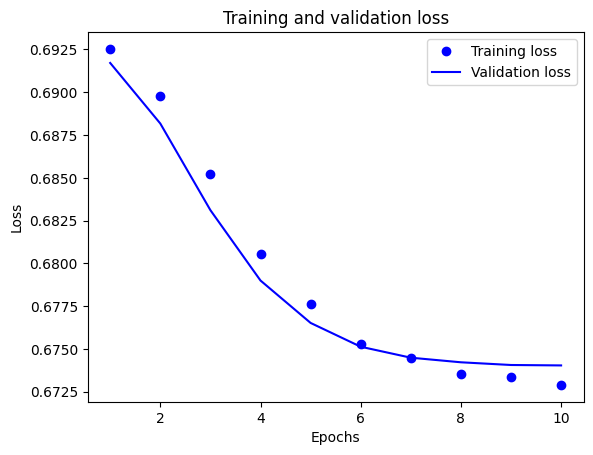

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Criação de Gráficos de Desempenho:
1. Histórico de Treinamento: history.history contém os valores de perda e precisão para cada época, tanto para o treino quanto para a validação. Isso é útil para visualizar o progresso do treinamento ao longo do tempo.

2. Plotagem de Gráficos: Os gráficos de perda e precisão são plotados para treinamento e validação. Eles são úteis para identificar overfitting, que é quando o modelo tem um bom desempenho nos dados de treino mas não generaliza bem para novos dados (validação).

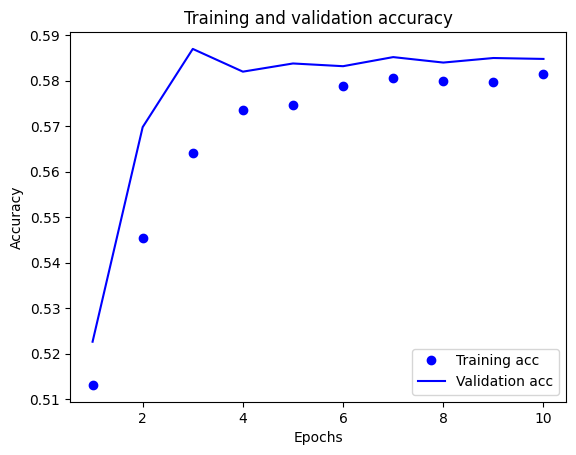

In [31]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Neste gráfico, os pontos representam a perda e exatidão do treinamento, enquanto as linhas sólidas representam a perda e exatidão da validação.

Sinais de Overfitting: Se a perda de validação aumenta e a precisão de validação diminui enquanto a perda de treinamento continua a diminuir e a precisão de treinamento aumenta, isso indica overfitting. Neste caso, o modelo está aprendendo a memorizar os dados de treinamento, em vez de aprender generalizações aplicáveis a novos dados.

### Exportação do Modelo

No código acima, aplicamos a camada TextVectorization ao dataset antes de alimentar o modelo com texto. Para tornar o modelo capaz de processar strings brutas (por exemplo, para simplificar a implantação), é possível incluir a camada TextVectorization dentro do modelo, o que também já foi pensado anteriormente. Para isso criaremos um novo modelo usando os pesos recém treinados, vejamos:

In [32]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandle

2024-01-12 20:38:52.749114: I tensorflow/core/common_runtime/placer.cc:125] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:38:52.749150: I tensorflow/core/common_runtime/placer.cc:125] sequential_1_text_vectorization_string_lookup_none_lookup_lookuptablefindv2_table_handle: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:38:52.749154: I tensorflow/core/common_runtime/placer.cc:125] sequential_1_text_vectorization_string_lookup_none_lookup_lookuptablefindv2_default_value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 20:38:52.749158: I tensorflow/core/common_runtime/placer.cc:125] sequential_1_text_vectorization_string_lookup_equal_y: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:38:52.749161: I tensorflow/core/common_runtime/placer.cc:125] sequential_1_text_vectorization_string_lookup_selectv2_t: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-01-12 20:38:52.749164: I tensorflow/core/commo

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_37957 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_37957 in device /job:localhost/replica:0/task:0/device:GPU:0
  4/782 [..............................] - ETA: 18s - loss: 0.6613 - accuracy: 0.6094 Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_37957 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/repl

a. Incluir a Camada de Vectorização: Incorporar a camada TextVectorization no modelo permite processar texto bruto (strings). Isso facilita a implantação, pois o modelo pode aceitar texto diretamente, sem necessidade de pré-processamento externo.

b. Avaliação do Modelo Exportado: Ao avaliar este novo modelo com raw_test_ds (que contém strings brutas), verifica-se que a inclusão da camada de vetorização não afetou o desempenho.

### Inferência de dados novos
Para fazer previsões para novos exemplos, basta chamar model.predict().

'model.predict(examples)': Permite fazer previsões em novos exemplos de texto. As saídas são probabilidades, indicando a confiança do modelo em relação a cada classe.

Ao incluir a lógica de pré-processamento de texto dentro do modelo, podemos exportar um modelo para produção que simplifica a implantação e reduz o potencial de desvio de treinamento/teste.

Há uma diferença de desempenho que devemos considerar ao escolher onde aplicar a camada TextVectorization. Ao usá-la fora do modelo, você pode fazer o processamento assíncrono na CPU e armazenar os dados em buffer ao treinar na GPU. Portanto, se você estiver treinando seu modelo na GPU, deve escolher essa opção para obter o melhor desempenho ao desenvolver o modelo. Depois, quando você estiver pronto para preparar a implantação, inclua a camada TextVectorization dentro do modelo.

In [33]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

2024-01-12 20:51:13.363258: I tensorflow/core/common_runtime/placer.cc:125] start: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:51:13.363317: I tensorflow/core/common_runtime/placer.cc:125] stop: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:51:13.363332: I tensorflow/core/common_runtime/placer.cc:125] step: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:51:13.363352: I tensorflow/core/common_runtime/placer.cc:125] RangeDataset: (RangeDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:51:13.363365: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:51:13.366258: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:51:13.366277: I tensorflow/core/common_runtime/placer.cc:125] count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-01-12 20:5

1/1 [==============================] - 0s 142ms/step


array([[0.7265105],
       [0.7219199],
       [0.7166643]], dtype=float32)

## Considerações Sobre Desempenho
Processamento na CPU vs. GPU: Ao treinar na GPU, pode ser melhor realizar o processamento de texto na CPU, enquanto a GPU se concentra no treinamento do modelo. Posteriormente, para implantação, incluir a camada de vetorização no modelo para simplificar o pipeline de inferência.

# Exercício:
Classificação multiclasse para perguntas do Stack Overflow
Este tutorial mostrou como treinar um classificador binário do zero usando o dataset do IMDB. Você pode fazer um exercício: modifique este notebook para treinar um classificador multiclasse que preveja a tag de uma pergunta de programação feita no Stack Overflow.

Um dataset foi preparado para uso, contendo o texto de milhares de perguntas de programação (por exemplo, "Como posso ordenar um dicionário por valor no Python?") publicadas no Stack Overflow. Cada pergunta é rotulada com exatamente uma tag (Python, CSharp, JavaScript ou Java). Sua tarefa é receber uma pergunta como entrada e prever a tag apropriada, que, neste caso, é Python.

Você usará um dataset que contém milhares de perguntas extraídas do dataset público do Stack Overflow, que é bem maior, no BigQuery, contendo mais de 17 milhões de publicações.

Após baixar o dataset, você verá que ele tem uma estrutura de diretórios similar ao dataset do IMDB utilizado anteriormente:

train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
Observação: para aumentar a dificuldade do problema de classificação, as ocorrências das palavras Python, CSharp, JavaScript e Java nas perguntas de programação foram substituídas pela palavra blank (em branco), já que diversas perguntas contêm a linguagem de programação em questão.

Para fazer este exercício, você deve modificar este notebook para que funcione com o dataset do Stack Overflow das seguintes maneiras:

Na parte superior do notebook, atualize o código que baixa o dataset do IMDB com o código que baixa o dataset do Stack Overflow, que já foi preparado. Como o dataset do Stack Overflow tem uma estrutura de diretórios parecida, você não precisará fazer muitas modificações.

Modifique a última camada do modelo para Dense(4), pois agora há quatro classes de saída.

Ao compilar o modelo, altere a perda para tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True). Esta é a função de perda correta a ser usada para problemas de classificação muilticlasse, quando os rótulos de cada classe são inteiros (neste caso, podem ser 0, 1, 2 ou 3). Além disso, altere as métricas para metrics=['accuracy'], já que este é um problema de classificação multicasse (tf.metrics.BinaryAccuracy é usado somente para classificadores binários).

Ao plotar a precisão ao longo do tempo, altere binary_accuracy e val_binary_accuracy para accuracy e val_accuracy, respectivamente.

Após fazer essas alterações, você poderá treinar um classificador multiclasse.

In [36]:
# https://github.com/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/keras/text_classification.ipynb